In [74]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [75]:
data_dir = r'E:\Jupyter\Samples\CoffeeDisease_Samples'

In [76]:
class_labels = ['Cercospora', 'Coffee Wilt', 'Healthy', 'Leaf Rust', 'Yellow Leaf Disease', 'Green Algae']

In [77]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [78]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [79]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [80]:
train_size = int(0.8 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) 

In [81]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [82]:
print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 783
Length of validation dataset: 196


In [83]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0


In [84]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [85]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [86]:
# Create the CNN model
model = resnet


In [87]:
# Check for available GPUs

device = torch.device("cuda")



In [88]:
# Move the model to the GPU
model = model.to("cuda")


In [89]:
# Get the total number of samples and the number of samples per class
total_samples = 0
samples_per_class = []
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        num_samples = len(os.listdir(class_dir))
        total_samples += num_samples
        samples_per_class.append(num_samples)
        print(f"Number of images in {label}: {num_samples}")

# Calculate the class weights
class_weights = [total_samples / x for x in samples_per_class]
weights = torch.tensor(class_weights).to("cuda")

criterion = nn.BCEWithLogitsLoss(pos_weight=weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)


Number of images in Cercospora: 590
Number of images in Coffee Wilt: 53
Number of images in Healthy: 160
Number of images in Leaf Rust: 56
Number of images in Yellow Leaf Disease: 76
Number of images in Green Algae: 44


In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    precision = precision_score(labels, preds, average=None, zero_division=0)
    recall = recall_score(labels, preds, average=None, zero_division=0)
    f1 = f1_score(labels, preds, average=None, zero_division=0)

    return precision, recall, f1

Epoch 1/32
----------
train Loss: 1.0262 Acc: 0.3282
val Loss: 0.7511 Acc: 0.5714
Epoch 2/32
----------
train Loss: 0.6888 Acc: 0.6028
val Loss: 0.5589 Acc: 0.6837
Epoch 3/32
----------
train Loss: 0.6034 Acc: 0.5760
val Loss: 0.5026 Acc: 0.6020
Epoch 4/32
----------
train Loss: 0.4898 Acc: 0.6501
val Loss: 0.4834 Acc: 0.6378
Epoch 5/32
----------
train Loss: 0.4547 Acc: 0.6679
val Loss: 0.4287 Acc: 0.7092
Epoch 6/32
----------
train Loss: 0.4185 Acc: 0.7063
val Loss: 0.4199 Acc: 0.7449
Epoch 7/32
----------
train Loss: 0.3975 Acc: 0.6960
val Loss: 0.3835 Acc: 0.7296
Epoch 8/32
----------
train Loss: 0.4041 Acc: 0.6731
val Loss: 0.3775 Acc: 0.7347
Epoch 9/32
----------
train Loss: 0.3799 Acc: 0.7101
val Loss: 0.3855 Acc: 0.7143
Early stopping counter: 1 out of 6
Epoch 10/32
----------
train Loss: 0.3514 Acc: 0.7331
val Loss: 0.3114 Acc: 0.7041
Epoch 11/32
----------
train Loss: 0.3605 Acc: 0.7356
val Loss: 0.3611 Acc: 0.6480
Early stopping counter: 1 out of 6
Epoch 12/32
----------
tra

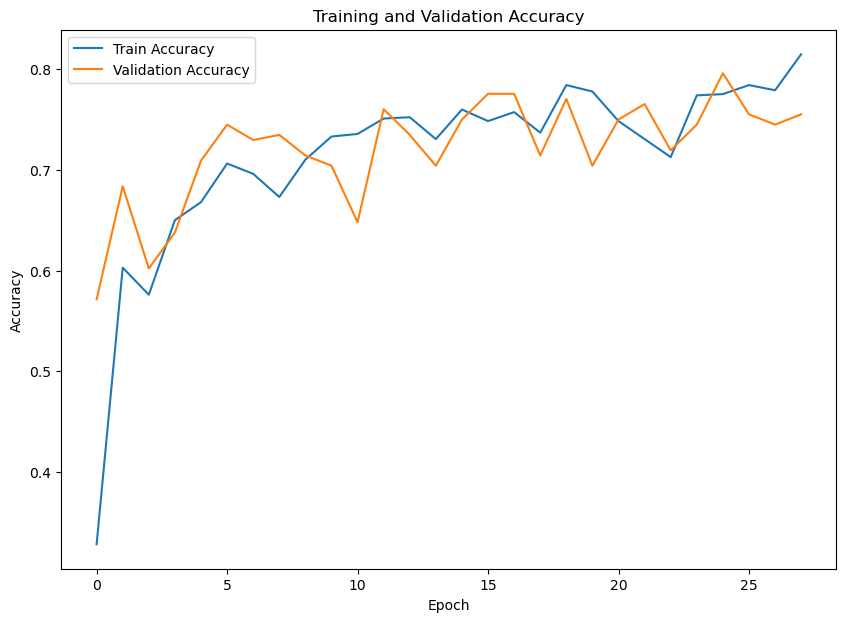

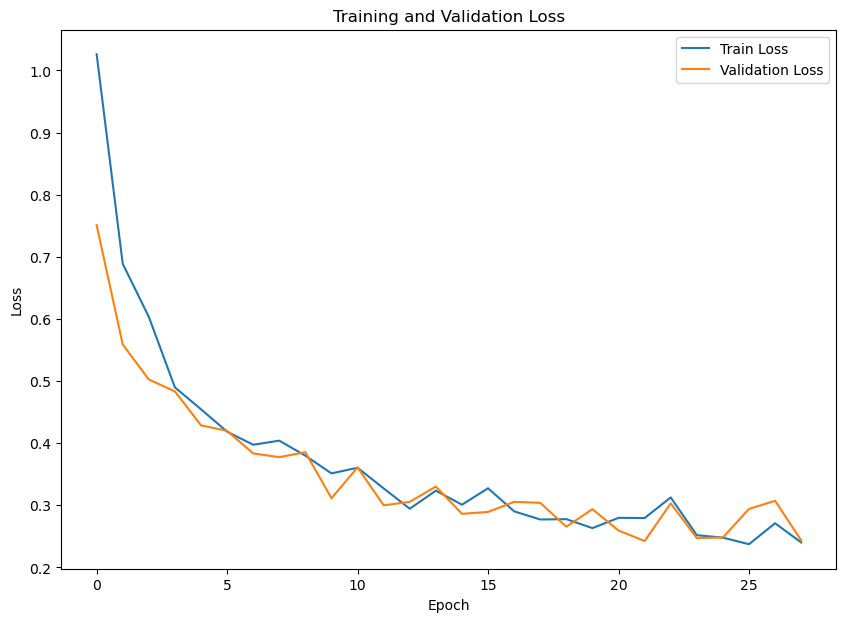

Best val Loss: 0.2425
Best val Acc: 0.7959


In [92]:
def train_model(model, criterion, optimizer, num_epochs=32, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Early stopping details
    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  # Flag to indicate if early stopping occurred

    for epoch in range(num_epochs):
        
        if early_stop:  # Check if early stopping occurred
            print('Breaking out of epoch loop due to early stopping.')
            break  # Break out of the epoch loop
  
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().float() 

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                preds = outputs > 0.5
                corrects = (preds == labels.byte()).all(1).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Check if early stopping conditions are met
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  # Set the early stopping flag
                        break  # Break out of the phase loop

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, num_epochs=32, patience=6)

# Plot metrics (accuracy and loss)
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)

torch.save(model.state_dict(), 'model.pth')

def evaluate_model(model, criterion, data_loader):
    model.eval()  # set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    # Initialize lists for saving precision, recall, and F1 score
    precision_list = []
    recall_list = []
    f1_list = []

    for inputs, labels in data_loader:
        inputs = inputs.cuda()
        labels = labels.cuda().float()

        with torch.no_grad():  # deactivate autograd
            outputs = model(inputs)
            # Get the probabilities from the outputs
            probs = torch.sigmoid(outputs)
            # Apply a threshold of 0.5
            preds = probs > 0.5
            loss = criterion(outputs, labels)

        # Calculate the number of correct predictions
        corrects = (preds == labels.byte()).all(1).sum().item()
        running_corrects += corrects
        running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        precision, recall, f1 = calculate_metrics(preds, labels)
        precision_list.append(precision.mean())
        recall_list.append(recall.mean())
        f1_list.append(f1.mean())

    total_loss = running_loss / len(data_loader.dataset)
    total_acc = running_corrects / len(data_loader.dataset)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')
    print(f'Precision: {avg_precision:.2f} Recall: {avg_recall:.2f} F1 Score: {avg_f1:.2f}')

# Load the saved model
model.load_state_dict(torch.load('model.pth'))

# Evaluate the model on the test dataset
evaluate_model(model, criterion, test_loader)

In [94]:
# Initialize the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(class_labels) 
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved parameters
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
# Don't forget to set the model to evaluation mode if you're doing inference
model.eval()

# Define the prediction function
def predict_image(image_path, model, threshold=0.5):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        # Get the probabilities from the outputs
        probs = torch.sigmoid(output)
        # Apply a threshold
        preds = probs > threshold
        # Get the indices of the positive predictions
        positive_indices = [i for i, x in enumerate(preds[0]) if x]
        # Return the corresponding class labels
        return [class_labels[i] for i in positive_indices]

# Use the prediction function
image_path = "E:\Jupyter\ML\ValidationSamples\CLR (3).jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  ['Cercospora']
